In [ ]:
!pip install SimpleITK

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test_dataset = pd.read_parquet('/content/drive/MyDrive/Project COMP MSc 2024 25/Kaggle & Oasis Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet')
test_dataset.head()


,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [ ]:
train_dataset = pd.read_parquet('/content/drive/MyDrive/Project COMP MSc 2024 25/Kaggle & Oasis Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet')
train_dataset.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [ ]:
def preprocess_dataset(data):
  x = []
  y = []
  for i in range(len(data)):
    instance = data.iloc[i]
    img = instance['image']
    img_bytes = img['bytes']
    img_label = instance['label']
    np_array = np.frombuffer(img_bytes, np.uint8)
    image = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    if image is not None:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if image is not None:
      x.append(image)
      y.append(img_label)
    else:
      print("ignoring an image")

  return x, y


In [ ]:
x_train ,y_train = preprocess_dataset(train_dataset)

In [ ]:
Counter(y_train)

Counter({2: 2566, 0: 724, 3: 1781, 1: 49})

In [ ]:
x_test, y_test = preprocess_dataset(test_dataset)

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
# Separate the data by class
X_train_by_class = {label: [] for label in np.unique(y_train)}
for i, label in enumerate(y_train):
    X_train_by_class[label].append(x_train[i])

# Convert lists to arrays for each class
X_train_by_class = {label: np.array(images) for label, images in X_train_by_class.items()}

# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the target count for each class (let's balance them to the majority class, 2566)
target_count = max(Counter(y_train).values())

# Augment the underrepresented classes
augmented_images = []
augmented_labels = []

for label, images in X_train_by_class.items():
    current_count = len(images)
    if current_count < (len(images) + 785) and label == 0 or label == 1:
        needed = 785
        print(f"Generating {needed} new images for class {label}...")

        # Use datagen to create the necessary samples
        i = 0
        for X_batch, _ in datagen.flow(images, np.full(current_count, label), batch_size=32):
            for img in X_batch:
                augmented_images.append(img)
                augmented_labels.append(label)
                i += 1
                if i >= needed:
                    break
            if i >= needed:
                break

# **Convert augmented_images to a NumPy array with 4 dimensions**
augmented_images = np.array(augmented_images)

# Check shapes before concatenation
print("Original X_train shape:", x_train.shape)
print("Augmented images shape:", augmented_images.shape)

# Concatenate the original and augmented images and labels
X_train_balanced = np.concatenate([x_train, augmented_images], axis=0)
y_train_balanced = np.concatenate([y_train, augmented_labels], axis=0)

# Confirm the new distribution
print("New class distribution:", Counter(y_train_balanced))


Generating 785 new images for class 0...
Generating 785 new images for class 1...
Original X_train shape: (5120, 128, 128, 3)
Augmented images shape: (1570, 128, 128, 3)
New class distribution: Counter({2: 2566, 3: 1781, 0: 1509, 1: 834})


In [ ]:
flatten_ximg = [X_train_balanced[i].flatten() for i in range(len(X_train_balanced))]
flatten_yimg = [x_test[i].flatten() for i in range(len(x_test))]

## Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.9086

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.81      0.86       172
           1       0.92      0.80      0.86        15
           2       0.92      0.93      0.93       634
           3       0.89      0.91      0.90       459

    accuracy                           0.91      1280
   macro avg       0.91      0.87      0.89      1280
weighted avg       0.91      0.91      0.91      1280



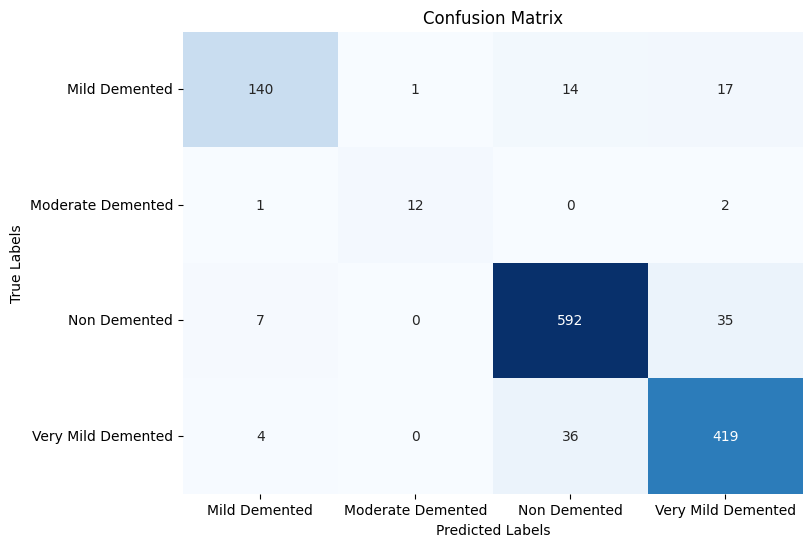

In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=150)
model.fit(flatten_ximg, y_train_balanced)

# Make predictions
y_pred = model.predict(flatten_yimg)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

#Create a heatmap plot of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'],
            yticklabels=['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



# Naive Bayes


Test Accuracy: 0.5391

Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.01      0.01       172
           1       0.00      0.00      0.00        15
           2       0.64      0.69      0.66       634
           3       0.43      0.55      0.49       459

    accuracy                           0.54      1280
   macro avg       0.29      0.31      0.29      1280
weighted avg       0.48      0.54      0.50      1280



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


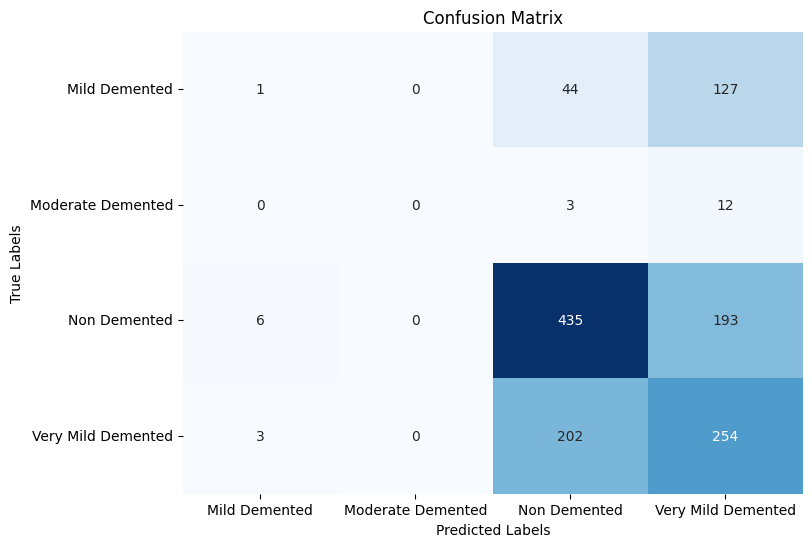

In [ ]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(flatten_ximg, y_train_balanced)

y_pred = gaussian_nb.predict(flatten_yimg)


accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

#Create a heatmap plot of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'],
            yticklabels=['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



# XGBoost

In [ ]:
xgb = XGBClassifier(eval_metric='mlogloss')
xgb.fit(flatten_ximg, y_train_balanced)

# Make predictions
y_pred = xgb.predict(flatten_yimg)


accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

#Create a heatmap plot of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'],
            yticklabels=['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Random Forest

Test Accuracy: 0.9148
              precision    recall  f1-score   support

           0       0.99      0.76      0.86       172
           1       1.00      0.20      0.33        15
           2       0.90      0.99      0.94       634
           3       0.92      0.89      0.91       459

    accuracy                           0.91      1280
   macro avg       0.95      0.71      0.76      1280
weighted avg       0.92      0.91      0.91      1280



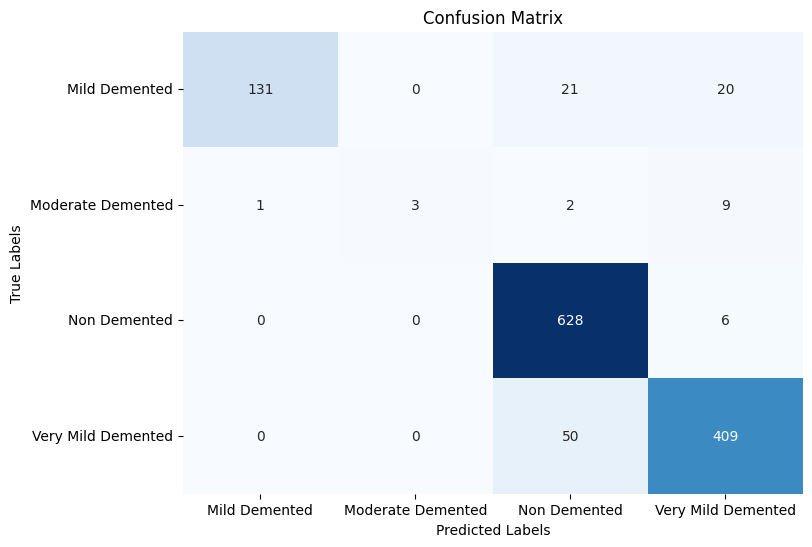

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(flatten_ximg, y_train_balanced)

# Predict on the test set
y_pred = rf_model.predict(flatten_yimg)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print(classification_report(y_test, y_pred))

#Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

#Create a heatmap plot of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'],
            yticklabels=['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()